In [1]:
import matplotlib
import local_models.local_models
import local_models.algorithms
import local_models.utils
import local_models.linear_projections
import local_models.loggin
import local_models.TLS_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.cluster
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import pandas as pd
import scipy.fftpack
import gc
import patched_gpr
import sklearn.gaussian_process as gp
import importlib
np.random.seed(1)




logger = logging.getLogger(__name__)

#reload(local_models.local_models)
#reload(lm)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')

In [2]:
HZ=250
EEG_CHANNELS=21
RUN=1
SECONDS_OF_SIGNAL=100
l = HZ*SECONDS_OF_SIGNAL
subsample_rate=50
bandwidth = 500
n = 2*bandwidth-1

In [3]:
mpl.rcParams['figure.figsize'] = [16.0*SECONDS_OF_SIGNAL/20, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*2)

In [4]:
def adjust_ax_labels(axs, rng, n_ticks=8, hz=250):
    try:
        axs_iterator = iter(axs)
    except TypeError as te:
        axs_iterator = iter([axs])
    for ax in axs_iterator:
        ax.axis("off")
    ax.axis("on")
    x_ticks = np.linspace(rng[0],rng[1],n_ticks)
    x_tick_labels = x_ticks/hz
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(list(map(lambda x: "{:.01f}".format(x), x_tick_labels)))
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)        

In [5]:
#HB suggests using std(X)*n**(-1/5)... since std(X) depends crucially on the length of the signal, how can this help?

In [6]:
project_dir = "../data/todd_eeg_gpr_single_rbf_run{:03d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

In [7]:
data_dir = "/home/brown/disk2/eeg/Phasespace/Phasespace/data/eeg-text"

In [8]:
data_info = pd.read_csv(os.path.join(data_dir, "fileinformation.csv"), skiprows=1).iloc[:,2:]

In [9]:
data_info

,Unnamed: 2,Number of Records,Time of Seizure,Unnamed: 5,Point of Seizure,250
0,DAT.F00012,3963799,14040,NaN,3510000,3510000
1,DAT.F00013,3632699,12720,NaN,3180000,3180000
2,DAT.F00016,4447824,15960,NaN,3990000,3990000
3,DAT.F00017,1827224,0,NaN,0,0
4,DAT.F00018,2985924,10020,NaN,2505000,2505000
5,DAT.F00019,3692374,12960,NaN,3240000,3240000
6,DAT.F00020,3270974,11280,NaN,2820000,2820000
7,DAT.F00022,2120524,0,NaN,0,0
8,DAT.F00024,3378499,11700,NaN,2925000,2925000
9,DAT.F00026,3370999,0,NaN,0,0


In [10]:
WHICH_DATA_FILE=5

In [11]:
data_file = data_info.iloc[WHICH_DATA_FILE,0]

In [12]:
data_epipoint = data_info.iloc[WHICH_DATA_FILE,4]

In [13]:
data_epipoint

3240000

In [14]:
dat = np.loadtxt(os.path.join(data_dir, data_file))

In [15]:
ictal_rng = (max(0,data_epipoint-l), min(dat.shape[0], data_epipoint+l))
non_ictal_rng = (max(0, int(data_epipoint/2)-l), min(dat.shape[0], int(data_epipoint/2)+l))
subsample_ictal_rng = (np.array(ictal_rng)/subsample_rate).astype(int)
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
index_X = np.arange(dat.shape[0]*1.).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(index_X.flatten())
nonictal_rng = (1000,1000+n) 
nonictal_X = np.arange(*nonictal_rng)

In [16]:
class GPR(patched_gpr.GaussianProcessRegressor):
    def fit(self, X,y,sample_weight=None, **kwargs):
        if "beta0" in kwargs:
            self.kernel.theta = kwargs["beta0"]
            del kwargs["beta0"]
        the_model = super().fit(X,y,sample_weight, **kwargs)
        self.coef_ = the_model.kernel_.theta
        self.intercept_ = np.empty((0,))
        return the_model

In [28]:
kernel = np.sum((
    np.prod((#delta waves
        gp.kernels.ConstantKernel(constant_value=1.0, constant_value_bounds=[0.001,1e10]),
        gp.kernels.RBF(length_scale=HZ/2, length_scale_bounds=[1e-5,1e5]))),
    gp.kernels.WhiteKernel(noise_level=1e-9, noise_level_bounds=[1e-9,1e-9])
))

## Fit exemplar GPR to get starting values

In [29]:
#a computationally convenient approximation to the beta... sig on [0,1]
def kumaraswamy(sig,a=1.,b=1.):
    return a*b*sig**(a-1)*(1-sig**a)**(b-1)
def spectrum(sig, d):
    f = scipy.fftpack.rfftfreq(sig.size, d=d)
    y = scipy.fftpack.rfft(sig)
    return f, y
def kumaraswamy_filter(sig,d,a=1.,b=1.):
    f, y = spectrum(sig, d)
    max_f = np.max(f)
    kumaraswamy_filter = kumaraswamy(f/max_f,a,b)
    kumaraswamy_filter /= np.max(kumaraswamy_filter) #scale units
    y *= kumaraswamy_filter
    filtered_sig = scipy.fftpack.irfft(y)
    return filtered_sig

In [30]:
filtered_dat0 = kumaraswamy_filter(dat[:,0],1/HZ,1.2,10.)

In [31]:
filtered_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=7, alpha=0)

In [32]:
exemplar_rng = (1000,1000+n) 
exemplar_X = np.arange(*exemplar_rng)
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)

In [33]:
filtered_exemplar_gpr = filtered_regressor.fit(exemplar_X.reshape(-1,1), filtered_dat0[slice(*exemplar_rng)],lm_kernel(np.abs(exemplar_X-np.mean(exemplar_X))))

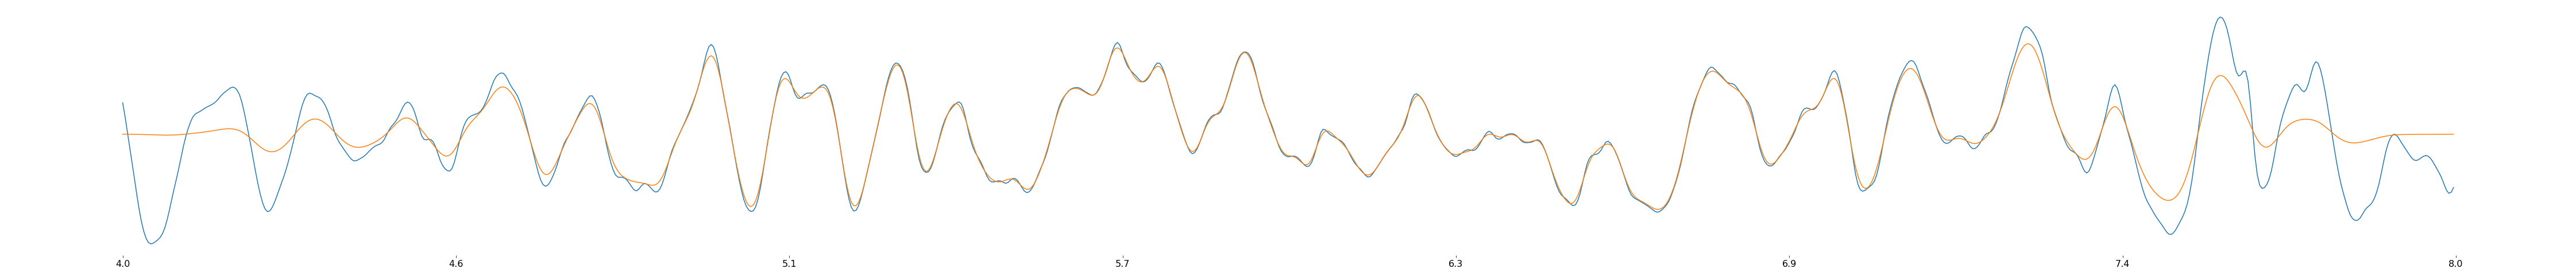

In [34]:
fig, axs = plt.subplots(1, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,exemplar_rng,hz=HZ)
axs.plot(exemplar_X, filtered_dat0[slice(*exemplar_rng)])
axs.plot(exemplar_X, filtered_exemplar_gpr.predict(exemplar_X.reshape(-1,1)))
plt.savefig(os.path.join(project_dir, "filtered_exemplar_gpr_rng{}.png".format(str(exemplar_rng))))

In [35]:
np.exp(filtered_exemplar_gpr.kernel_.theta)

array([3.95139973e+03, 4.79716330e+00, 1.00000000e-09])

In [36]:
filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
X = np.arange(filtered_dat0.shape[0]*1.).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
y = filtered_dat0
lm_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
filtered_gpr_models.fit(X,y,index=index)

In [ ]:
filtered_gpr_params = filtered_gpr_models.transform(X[ictal_rng[0]:ictal_rng[1]:subsample_rate,:],r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_ictal_rng[1] - subsample_ictal_rng[0])/10))

In [ ]:
def clear(fig, axs):
    for ax in axs:
        ax.clear()
    fig.clear()
    plt.close(fig)
    plt.close("all")

In [57]:
def plt_gpr_params(X, y, gpr_X, gpr_params, epipoint, kernel, filename, hz=HZ):
    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
    adjust_ax_labels(axs,(np.min(X), np.max(X)),hz=HZ)
    artists = []
    colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
    for var in range(gpr_params.shape[1]):
        c = next(colors)
        ar = axs[0].plot(gpr_X, gpr_params[:,var],c=c)
        artists.append(ar[0])
    c = next(colors)
    for ax in axs:
        ar = ax.axvline(epipoint,c=c,lw=5)
    artists.append(ar)
    c = next(colors)
    ar = axs[1].plot(X, y, c=c)
    artists.append(ar[0])
    axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + ["ictal point", "filtered eeg"],loc="lower left")
    plt.savefig(filename)
    clear(fig, axs)

In [ ]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,ictal_rng,hz=HZ)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for var in range(filtered_gpr_params.shape[1]):
    c = next(colors)
    ar = axs[0].plot(X[ictal_rng[0]:ictal_rng[1]:subsample_rate],filtered_gpr_params[:,var],c=c)
    artists.append(ar[0])
c = next(colors)
for ax in axs:
    ar = ax.axvline(data_epipoint,c=c,lw=5)
artists.append(ar)
c = next(colors)
ar = axs[1].plot(X[ictal_rng[0]:ictal_rng[1]],filtered_dat0[slice(*ictal_rng)],c=c)
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims])) + ["ictal point", "filtered eeg"],loc="lower left")
plt.savefig(os.path.join(project_dir, "filtered_gpr_params_subsamplerate{:07d}_kernel{}.png".format(subsample_rate, str(lm_kernel))))

## Filter the eeg to the range of normal brainwaves

In [ ]:
a = 1.2; b=10.
filtered_data_dir = os.path.join(data_dir, "filtered_data")
os.makedirs(filtered_data_dir, exist_ok=1)
filtered_data_filename = os.path.join(filtered_data_dir, "kumaraswamy_filtered_data_eeg{}_a{:05.02f}_b{:05.02f}".format(data_file, a, b))

In [ ]:
if not os.path.isfile(filtered_data_filename):
    filtered_dat = np.empty(dat[:,:EEG_CHANNELS].shape)
    for channel in range(EEG_CHANNELS):
        print(channel)
        filtered_dat[:,channel] = kumaraswamy_filter(dat[:,channel],1/HZ,a,b)
    np.savetxt(filtered_data_filename, filtered_dat)
else:
    filtered_dat = np.loadtxt(filtered_data_filename)

In [ ]:
transformed_data_dir = os.path.join(data_dir, "transformed_data_single_rbf_{:03d}".format(RUN))
os.makedirs(transformed_data_dir, exist_ok=1)

In [ ]:
timelog = local_models.local_models.loggin.TimeLogger(
    logger=logger, 
    how_often=1, total=EEG_CHANNELS, 
    tag="local gpr eeg transform eeg{}".format(data_file))

for channel in range(EEG_CHANNELS):
    with timelog:
        transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
        #fit an exemplar gpr to get optimizer starting parameters
        filtered_regressor = GPR(kernel=kernel, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        filtered_exemplar_gpr = filtered_regressor.fit(
            nonictal_X.reshape(-1,1), 
            filtered_dat[slice(*nonictal_rng),channel], 
            lm_kernel(np.abs(nonictal_X-np.mean(nonictal_X))))
        #fit the local models
        filtered_local_regressor = GPR(kernel=filtered_exemplar_gpr.kernel_, normalize_y=True, n_restarts_optimizer=0, alpha=0)
        y = filtered_dat[:,channel]
        filtered_gpr_models = local_models.local_models.LocalModels(filtered_local_regressor)
        filtered_gpr_models.fit(index_X,y,index=index)
        filtered_gpr_params = filtered_gpr_models.transform(index_X[ictal_rng[0]:ictal_rng[1]:subsample_rate,:],r=lm_kernel.support_radius()-1,weighted=True,kernel=lm_kernel,neighbor_beta0s=False, batch_size=int((subsample_ictal_rng[1] - subsample_ictal_rng[0])/10))
        np.savetxt(transformed_data_filename, filtered_gpr_params)

In [52]:
filtered_gpr_params.shape

(1000, 3)

In [ ]:
transformed_data_img_dir = os.path.join(transformed_data_dir, "transformed_data_imgs")
os.makedirs(transformed_data_img_dir, exist_ok=1)

In [58]:
gpr_X = index_X[ictal_rng[0]:ictal_rng[1]:subsample_rate,:]
X = index_X[slice(*ictal_rng),:]
for channel in range(EEG_CHANNELS):
    print(channel)
    transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
    transformed_data_img_filename = os.path.join(transformed_data_img_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.png".format(str(lm_kernel), str(ictal_rng), channel))
    y = filtered_dat[slice(*ictal_rng),channel]
    gpr_params = np.loadtxt(transformed_data_filename)
    plt_gpr_params(X, y, gpr_X, gpr_params, data_epipoint, kernel, transformed_data_img_filename)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [ ]:
import importlib; importlib.reload(local_models.algorithms)
importlib.reload(local_models.TLS_models)

In [ ]:
def fit_meanshift(gpr_paramses, kernel):
    mean_regressor = local_models.TLS_models.LinearODR_mD(0)
    mean_models = local_models.local_models.LocalModels(mean_regressor)
    mean_models.fit(gpr_paramses)
    for i, (dat, report) in enumerate(local_models.algorithms.local_tls_shift_till_convergence(
                mean_models, gpr_paramses, kernel=kernel, report=True)):
        if not i%100:
            #print(report)
            pass
    return dat

In [ ]:
def cleanup_meanshift(meanshifted_data, tol=1e-7): 
    import sklearn.neighbors
    bt = sklearn.neighbors.BallTree(meanshifted_data)
    bins = bt.query_radius(meanshifted_data, r=tol)
    cleanuped = np.empty(meanshifted_data.shape)
    for i, the_bin in enumerate(bins):
        cleanuped[i] = np.mean(meanshifted_data[the_bin], axis=0)
    return cleanuped

In [ ]:
def pick_optimal_meanshift_bandwidth(initial_bandwidths, gpr_paramses, iterations=7):
    #go middle of the road to get two clusters.
    #i.e. find the minimum bandwidth giving 3, the max giving 1, then take their average
    print(iterations)
    checked_bandwidths = []
    given_n_clusters = []
    if iterations == 0:
        return checked_bandwidths, given_n_clusters
    for bandwidth in initial_bandwidths:
        ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=bandwidth)
        fitted_meanshift = fit_meanshift(gpr_paramses, ms_kernel)
        fitted_meanshift = cleanup_meanshift(fitted_meanshift)
        observed_clusters = np.unique(fitted_meanshift, axis=0).shape[0]
        checked_bandwidths.append(bandwidth)
        given_n_clusters.append(observed_clusters)
    #get half of the ones, and half of the twos:
    the_ones = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==1]
    the_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]==2]
    the_more_than_twos = [checked_bandwidths[i] for i in range(len(checked_bandwidths)) if given_n_clusters[i]>2]
    median_the_ones = np.median(the_ones)
    median_the_more_than_twos = np.median(the_more_than_twos)
    median_the_twos = np.median(the_twos) if the_twos else np.mean([median_the_ones, median_the_more_than_twos])
    sub_checked, sub_n_clusters = pick_optimal_meanshift_bandwidth(
        np.concatenate((
            np.linspace(median_the_more_than_twos, median_the_twos, len(initial_bandwidths)),
            np.linspace(median_the_twos, median_the_ones, len(initial_bandwidths))
        )),
        gpr_paramses,
        iterations - 1
    )
    return checked_bandwidths + sub_checked, given_n_clusters + sub_n_clusters 

## Check out what happens when meanshift clustering gpr_params for different bandwidths

In [ ]:
bs, ns = pick_optimal_meanshift_bandwidth([1,5,13,34,89], gpr_params)

In [ ]:
sorted_bs_indices = sorted(list(range(len(bs))), key=lambda i: bs[i])
sorted_bs = [bs[i] for i in sorted_bs_indices]
sorted_ns = [ns[i] for i in sorted_bs_indices]

In [50]:
list(zip(sorted_ns, sorted_bs))

NameError: name 'sorted_ns' is not defined

In [ ]:
plt.plot(sorted_bs, sorted_ns)

### The optimal bandwidth is something that robustly gives 2 clusters

In [ ]:
optimal_bandwidth = np.median([bs[i] for i in range(len(bs)) if ns[i] ==2])
optimal_bandwidth

In [ ]:
ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=optimal_bandwidth)
single_channel_meanshift = fit_meanshift(gpr_params, ms_kernel)
single_channel_meanshift = cleanup_meanshift(single_channel_meanshift)

In [ ]:
uq, ind = np.unique(single_channel_meanshift,axis=0,return_inverse=True)

In [51]:
plt.plot(np.mean(uq,axis=1)[ind])

NameError: name 'uq' is not defined

In [ ]:
meanshifted_data_dir = os.path.join(data_dir, "meanshifted_data_{:03d}".format(RUN))
os.makedirs(meanshifted_data_dir, exist_ok=1)

In [ ]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for var in range(filtered_gpr_params.shape[1]-1):
    c = next(colors)
    ar = axs[0].plot(gpr_X,gpr_params[:,var],c=c)
    artists.append(ar[0])
    axs[1].plot(gpr_X,single_channel_meanshift[:,var],c=c)
c = next(colors)
for ax in axs:
    ar = ax.axvline(data_epipoint,c=c,lw=5)
artists.append(ar)
c = next(colors)
y = filtered_dat[slice(*ictal_rng),channel]
ar = axs[2].plot(X, y,c=c)
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims][:-1])) + ["ictal point", "filtered eeg"],loc="lower left")
plt.savefig(os.path.join(meanshifted_data_dir, "filtered_gpr_params_meanshifted_msb{:06.02f}_subsamplerate{:07d}_kernel{}.png".format(optimal_bandwidth, subsample_rate, str(lm_kernel))))

## Do the above things but for all channels... We'll just cram em into a single vector

In [ ]:
gpr_paramses = np.empty((gpr_params.shape[0], gpr_params.shape[1], EEG_CHANNELS))

In [ ]:
for channel in range(EEG_CHANNELS):
    print(channel)
    transformed_data_filename = os.path.join(transformed_data_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.dat".format(str(lm_kernel), str(ictal_rng), channel))
    transformed_data_img_filename = os.path.join(transformed_data_img_dir, "gpr_transformed_data_k{}_rng{}_channel{:03d}.png".format(str(lm_kernel), str(ictal_rng), channel))
    y = filtered_dat[slice(*ictal_rng),channel]
    gpr_params = np.loadtxt(transformed_data_filename)
    gpr_paramses[:,:,channel] = gpr_params

In [ ]:
flattened_params = gpr_paramses.transpose([0,2,1]).reshape(gpr_params.shape[0],-1)

In [49]:
flattened_params.shape

NameError: name 'flattened_params' is not defined

In [ ]:
np.linalg.norm(flattened_params[0]-flattened_params[1])

In [ ]:
ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=30)

In [ ]:
fitted_meanshift = fit_meanshift(flattened_params, ms_kernel)

In [48]:
fitted_meanshift.shape

NameError: name 'fitted_meanshift' is not defined

In [ ]:
fitted_meanshift = cleanup_meanshift(fitted_meanshift)

In [ ]:
plt.plot(fitted_meanshift[:,0])

## Get the optimal meanshift bandwidth for the "big" dataset

In [ ]:
bs_all_channels, ns_all_channels = pick_optimal_meanshift_bandwidth([13,34,89,150], flattened_params)

In [47]:
optimal_bandwidth_all_channels = np.median([bs_all_channels[i] for i in range(len(bs_all_channels)) if ns_all_channels[i] ==2])
optimal_bandwidth_all_channels

NameError: name 'bs_all_channels' is not defined

In [ ]:
ms_kernel = local_models.local_models.TriCubeKernel(bandwidth=optimal_bandwidth_all_channels)
all_channels_meanshift = fit_meanshift(flattened_params, ms_kernel)
all_channels_meanshift = cleanup_meanshift(all_channels_meanshift)

In [ ]:
plt.plot(np.mean(all_channels_meanshift,axis=1))

In [ ]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
adjust_ax_labels(axs,rng,hz=HZ)
artists = []
colors = (color for color in plt.rcParams['axes.prop_cycle'].by_key()['color'])
for var in range(filtered_gpr_params.shape[1]-1):
    c = next(colors)
    for channel in range(gpr_paramses.shape[2]):
        ar = axs[0].plot(gpr_X,gpr_paramses[:,var,channel],c=c)
        axs[1].plot(
            gpr_X,
            all_channels_meanshift[:,channel*filtered_gpr_params.shape[1] + var],
            c=c)
    artists.append(ar[0])
c = next(colors)
for ax in axs:
    ar = ax.axvline(data_epipoint,c=c,lw=5)
artists.append(ar)
c = next(colors)
for channel in range(gpr_paramses.shape[2]):
    y = filtered_dat[slice(*ictal_rng),channel]
    ar = axs[2].plot(X, y, c=c)
artists.append(ar[0])
axs[0].legend(artists, list(map(lambda x: type(x).__name__, [k for k in patched_gpr.decompose_kernels(kernel) if k.n_dims][:-1])) + ["ictal point", "filtered eeg"],loc="lower left")
plt.savefig(os.path.join(meanshifted_data_dir, "all_channels_gpr_params_meanshifted_msb{:06.02f}_subsamplerate{:07d}_kernel{}.png".format(optimal_bandwidth, subsample_rate, str(lm_kernel))))

In [ ]:
len(artists)